# Housing Data Analysis: Predicting Housing Prices

## Goal: Predict final sale price of a house in the Seattle area market

## Motivation: An early, acurate prediction will allow our amazing real estate startup to have a competitive edge on the competition.  
* Make limited, targeted recommendation to buyers rather than flooding them with properties to explore
 * Greater buyer experience
 * Less time to closing
* Target properties with higher final sale price to maximize commissions and fees
* Inform negotiation strategy
* Make us all rich when we get bought out by Trulia, Zillow, or some other bozos


# TLDR:

# Conclusions of preliminary analysis
* The data are clean and appear to contain meaningful signal for predicting sale price
* The best out-of-the-box model is a Random Forest Regressor
 * With pruning to reduce overfitting, it should improve significantly
 
# Next Steps
* Build and tune Random Forest Regressor
* Productionalize model so predictions can be made in the field by our agents

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.reset_defaults
sns.set_style(style='darkgrid')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'size'   : 16}
plt.rc('font', **font)
plt.ion()
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["figure.figsize"] = (20.0, 10.0)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)
%matplotlib inline

In [26]:
housing_df = pd.read_csv("../data/kc_house_data.csv")

Text(0.5, 1.0, 'Sales in the Seattle Area')

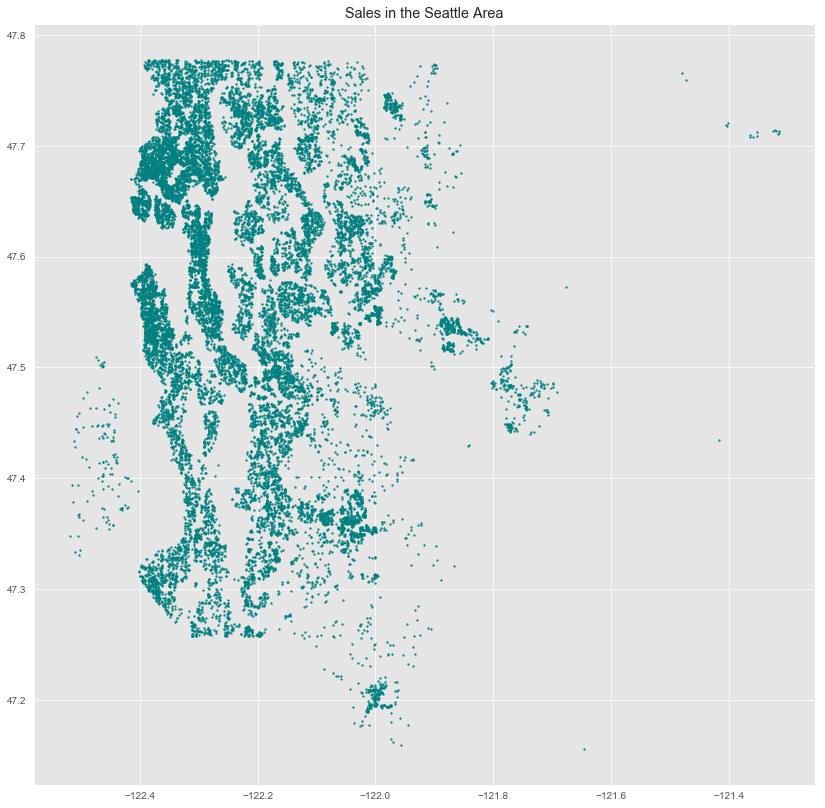

In [49]:
plt.figure(figsize=(14,14))
plt.scatter(housing_df['long'], housing_df['lat'], c="Teal", alpha=0.9, s=3)
plt.title("Sales in the Seattle Area")

In [27]:
# check time component
print("The first sale date is {}".format(housing_df['date'].min()[:8]))
print("The last sale date is {}".format(housing_df['date'].max()[:8]))

The first sale date is 20140502
The last sale date is 20150527


### Did average prices change over time during this year?

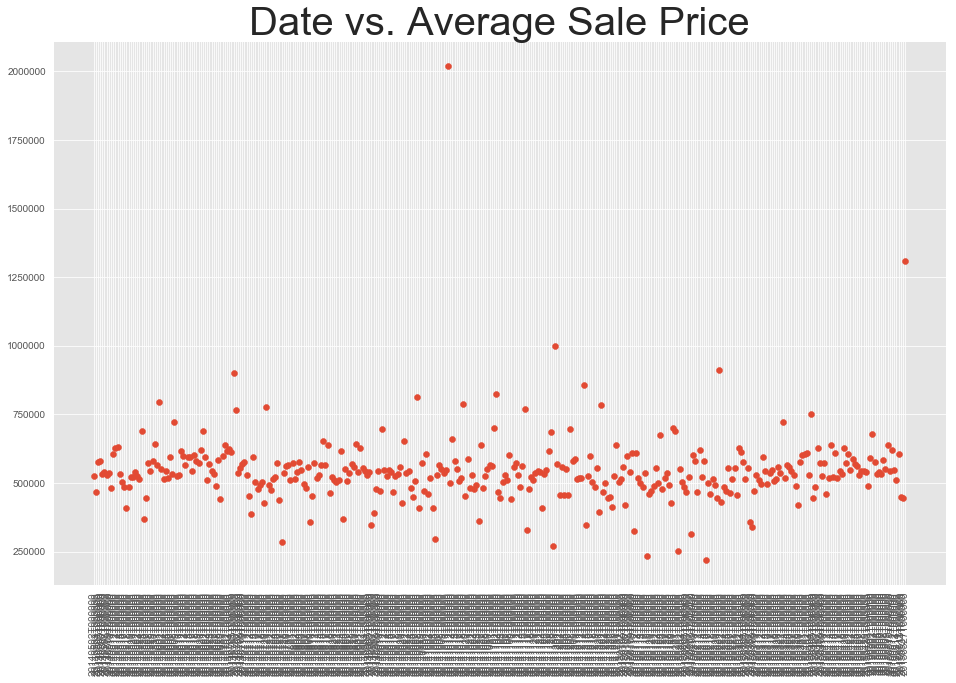

In [13]:
def av_price_vs_date(df):
    # plot avg price against date
    x=housing_df['date'].unique()
    x.sort()
    y = []
    for val in x:
        y.append(housing_df[housing_df['date'] == val]['price'].mean())
    plt.figure(figsize=(16,10))
    plt.scatter(x, y)
    plt.xticks(rotation=90)
    plt.title("Date vs. Average Sale Price", fontsize=40)
    plt.show()

av_price_vs_date(housing_df)

### No: average price over time is basically consistant.

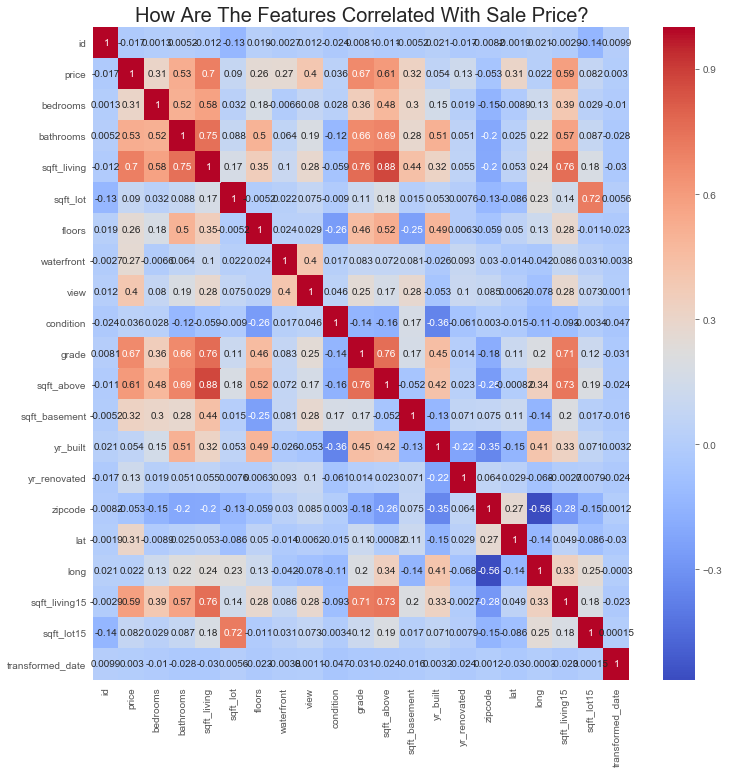

In [189]:
def target_corr_heatmap(df):
    # plots correlation coefficients for features against target in heatmap
    plt.figure(figsize=(12,12))
    sns.heatmap(housing_df.corr(), annot=True, cmap='coolwarm')
    plt.title("How Are The Features Correlated With Sale Price?", fontsize=20)
    plt.show()

target_corr_heatmap(housing_df)

In [29]:
sorted_corrs = abs(housing_df.corr().loc['price']).sort_values(ascending=False)
print("Features Sorted by Correlation Strength:\n\n{}".format(sorted_corrs))

Features Sorted by Correlation Strength:

price            1.000000
sqft_living      0.702044
grade            0.667463
sqft_above       0.605566
sqft_living15    0.585374
bathrooms        0.525134
view             0.397346
sqft_basement    0.323837
bedrooms         0.308338
lat              0.306919
waterfront       0.266331
floors           0.256786
yr_renovated     0.126442
sqft_lot         0.089655
sqft_lot15       0.082456
yr_built         0.053982
zipcode          0.053168
condition        0.036392
long             0.021571
id               0.016797
Name: price, dtype: float64


In [36]:
features = list(abs(housing_df.corr().loc['price']).sort_values(ascending=False).index[1:13])
features.append('long') #longitude added back in
print("Intial feature set (absolute correlation >= 0.10):\n\n{}".format(features))

Intial feature set (absolute correlation >= 0.10):

['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'view', 'sqft_basement', 'bedrooms', 'lat', 'waterfront', 'floors', 'yr_renovated', 'long']


### Looking at individual features

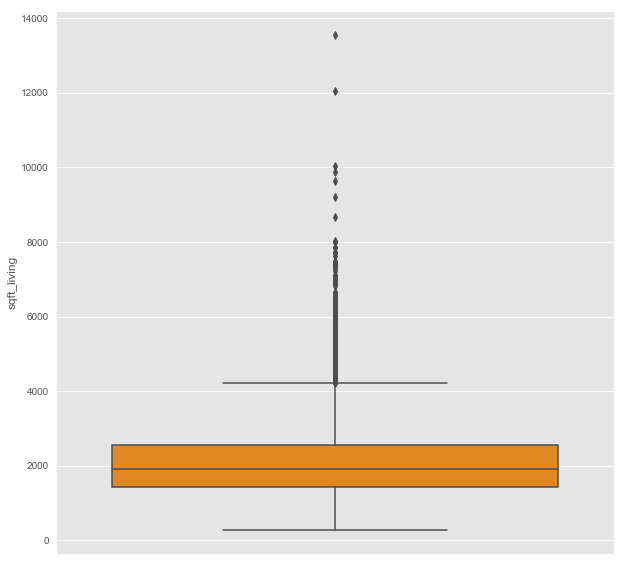

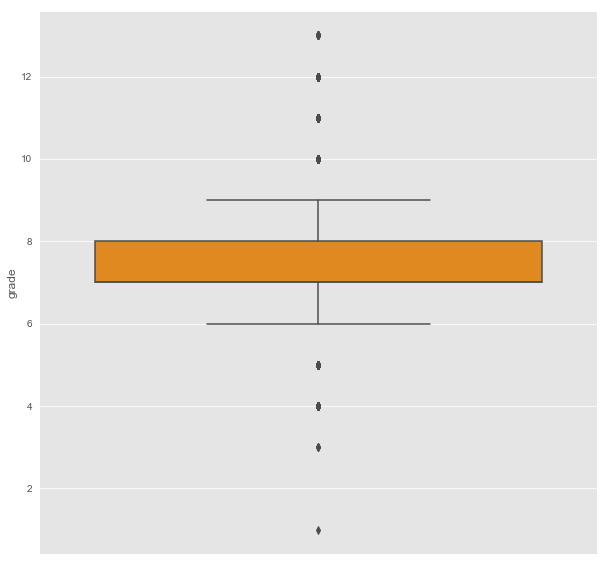

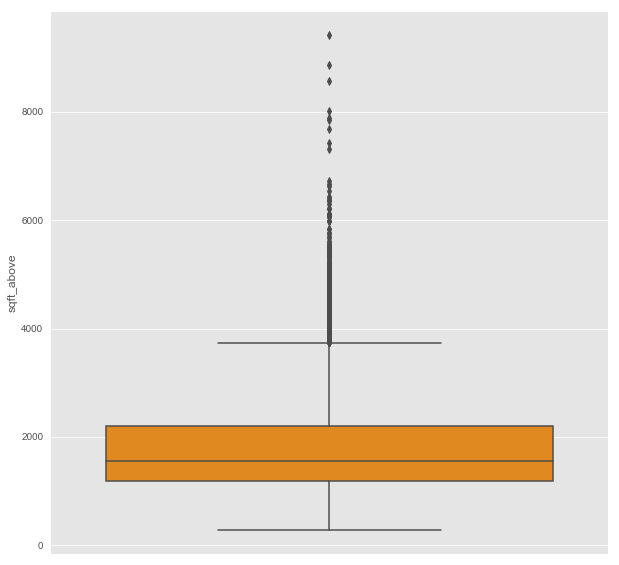

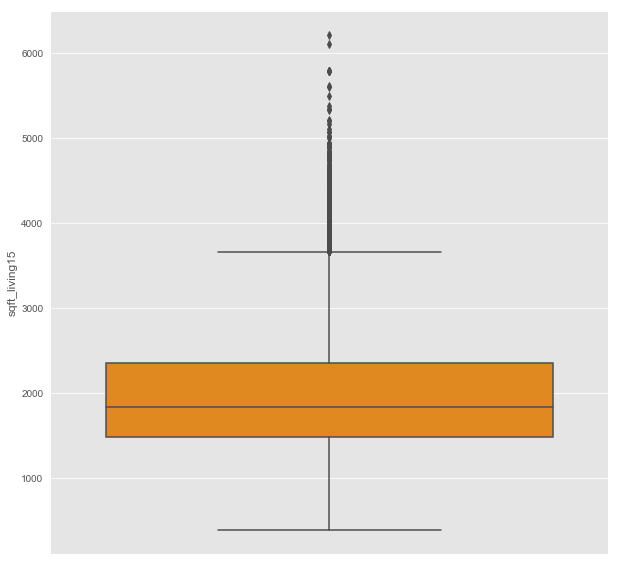

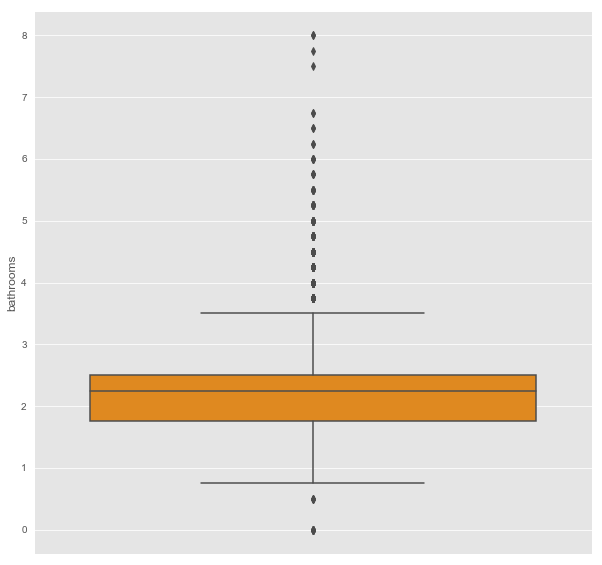

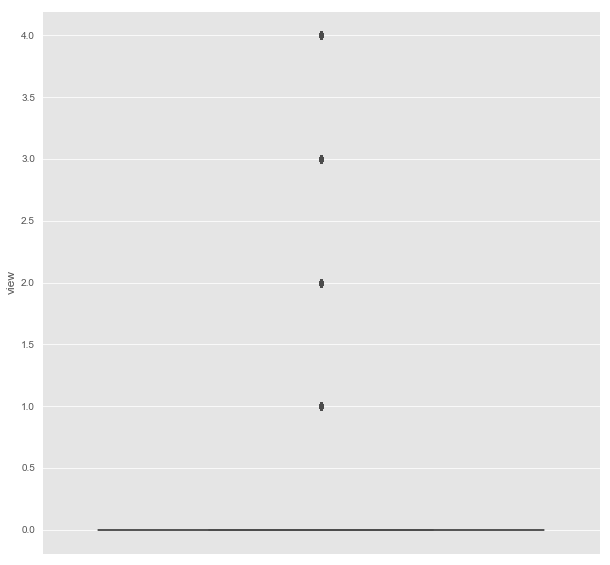

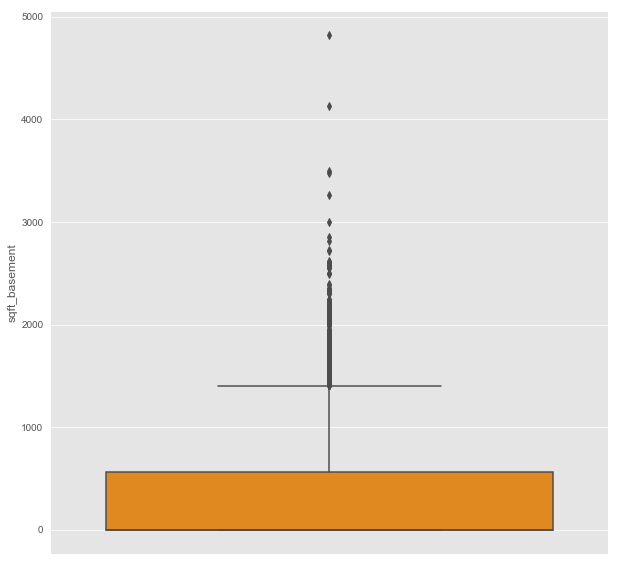

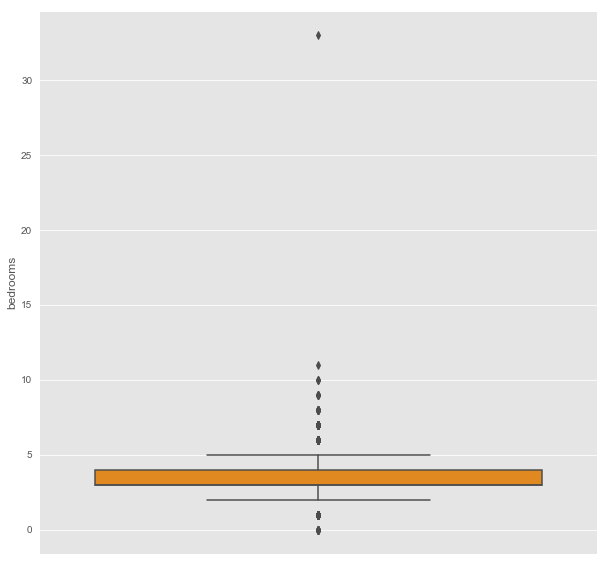

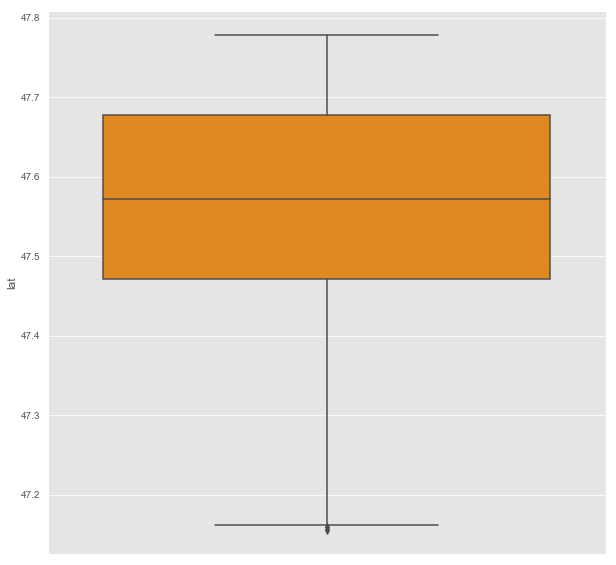

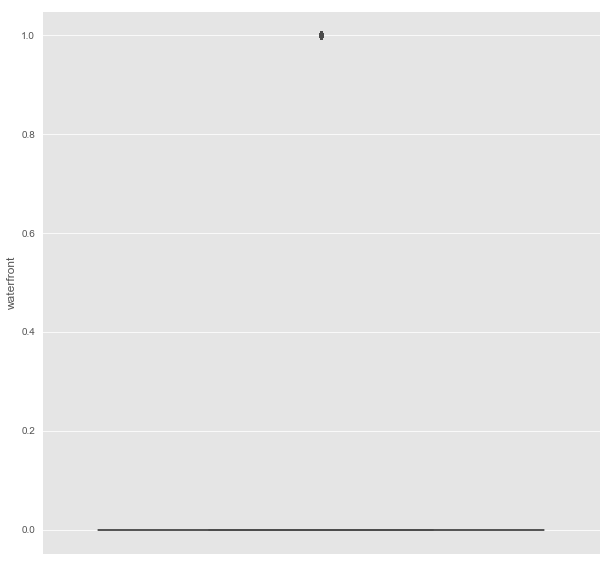

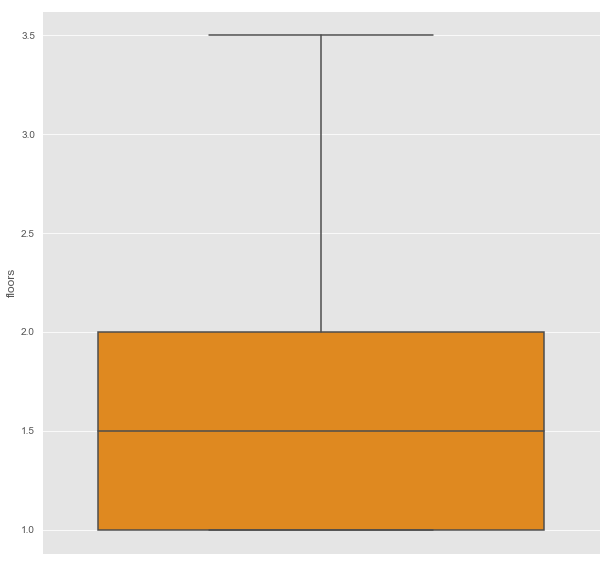

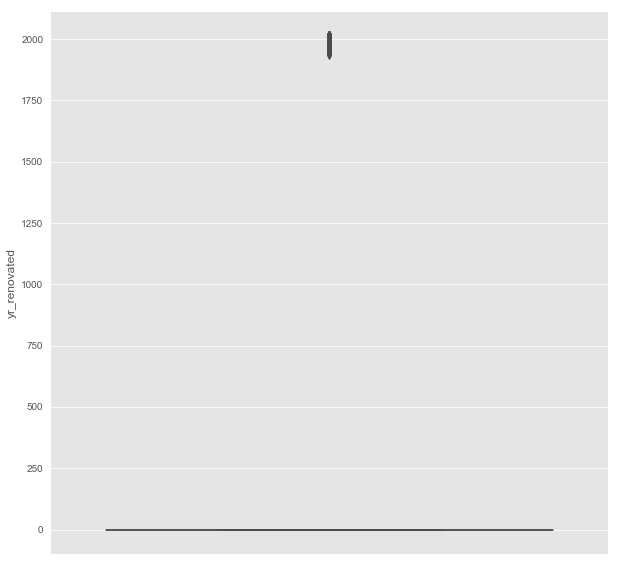

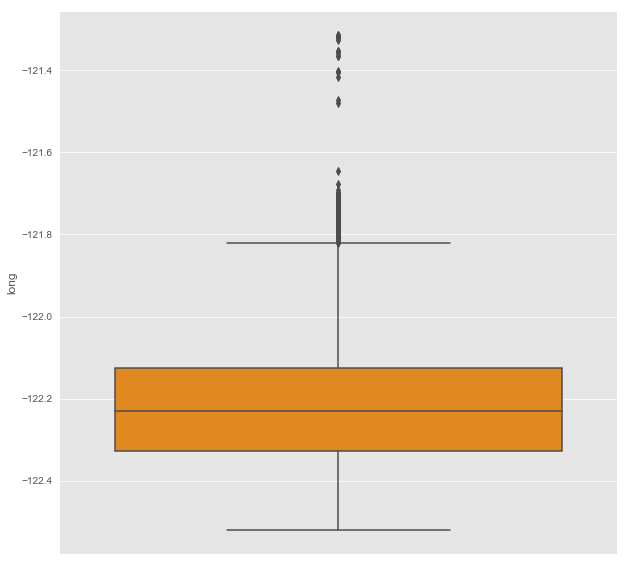

In [55]:
def feature_boxes(df, features):
    # make boxplots of features in dataframe
    for f in features:
        plt.figure(figsize=(10,10))
        sns.boxplot(df[f], orient='v', color='DarkOrange')

feature_boxes(housing_df, features)

## Observations from looking at the data
* Bedrooms has one crazy outlier with ~33 bedrooms.

In [53]:
housing_df[housing_df['bedrooms'] > 30]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,2402100895,20140625T000000,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


Given that this house has 1620 square feet of living space, it is likely a data entry error; impute value to "3"

### Features vs Target

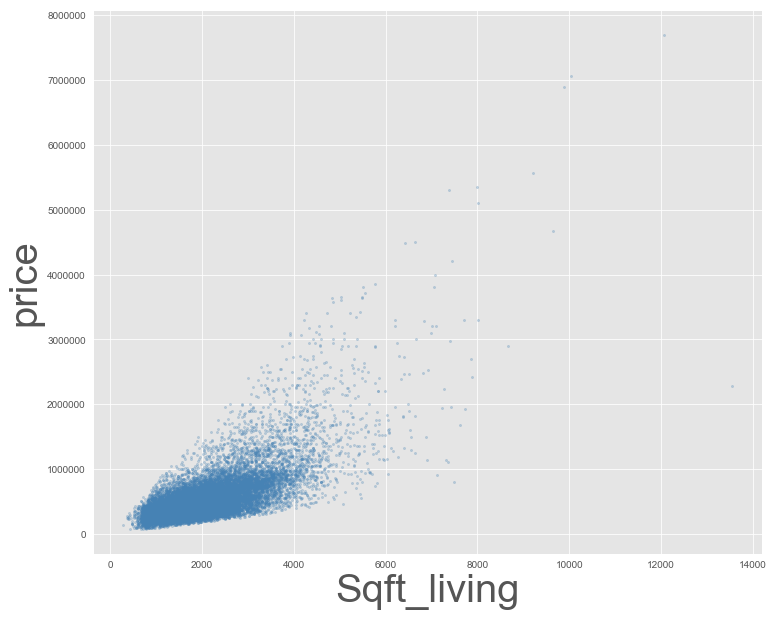

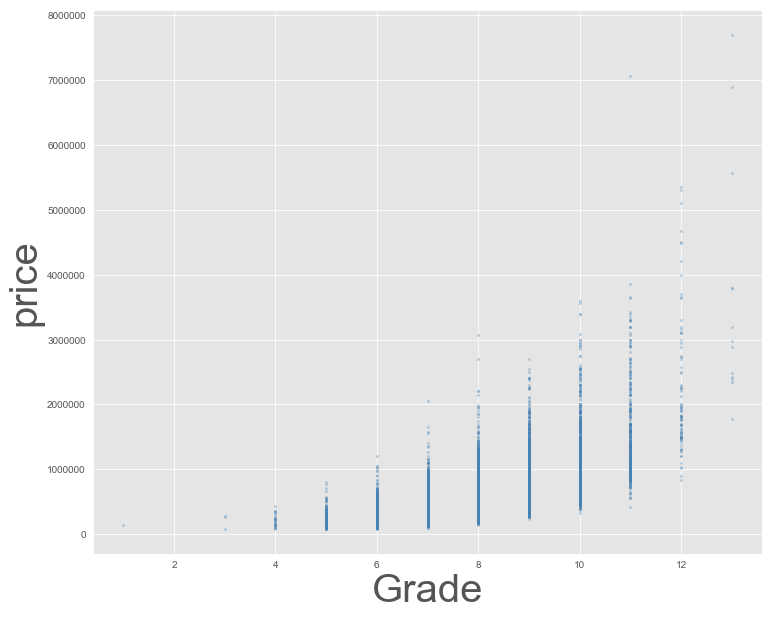

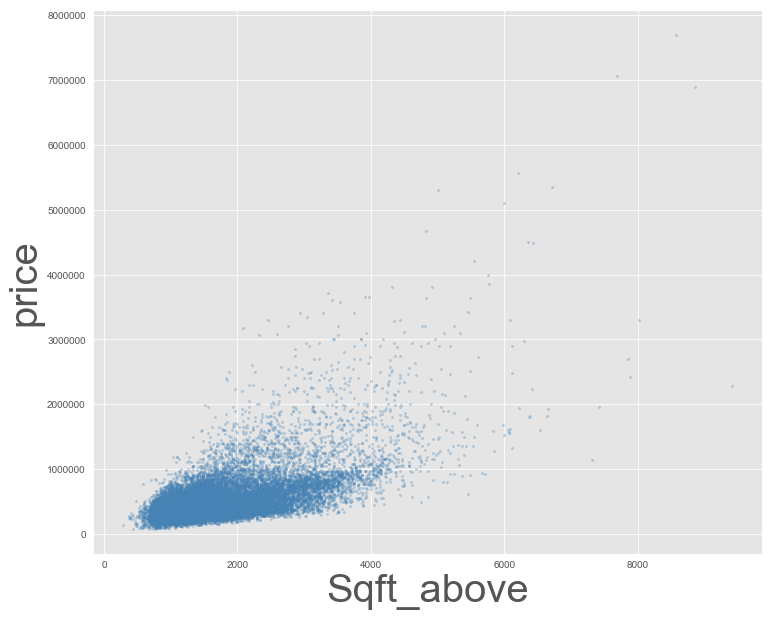

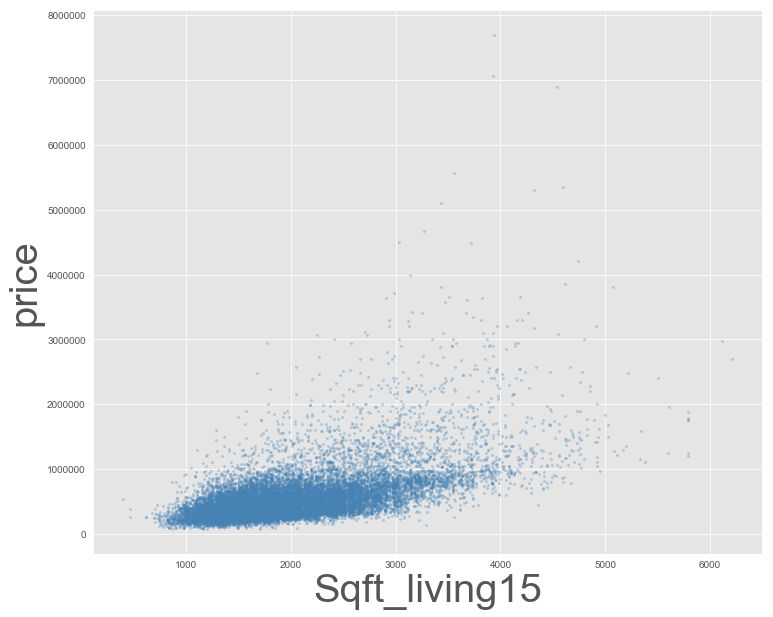

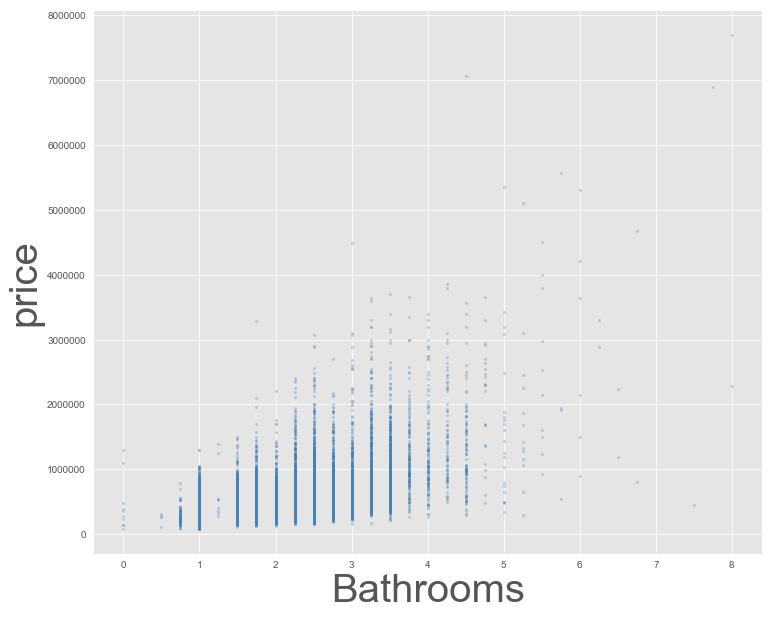

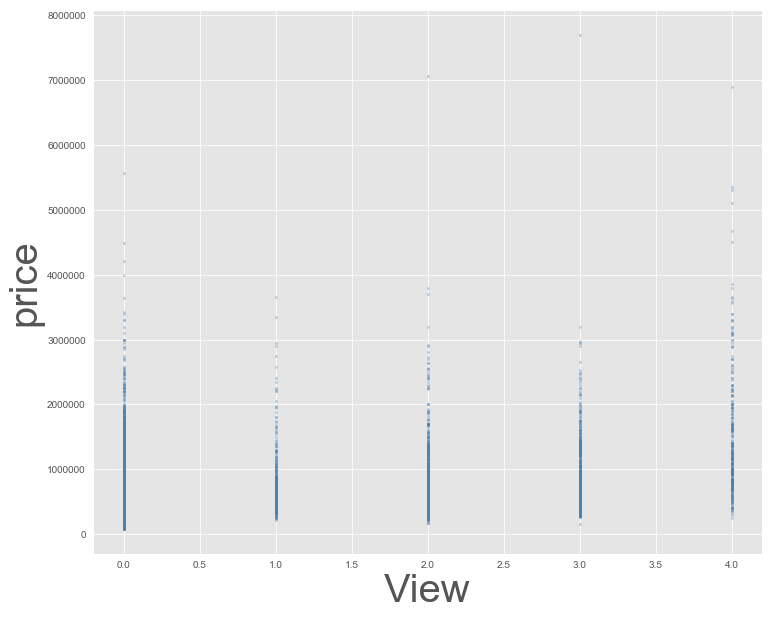

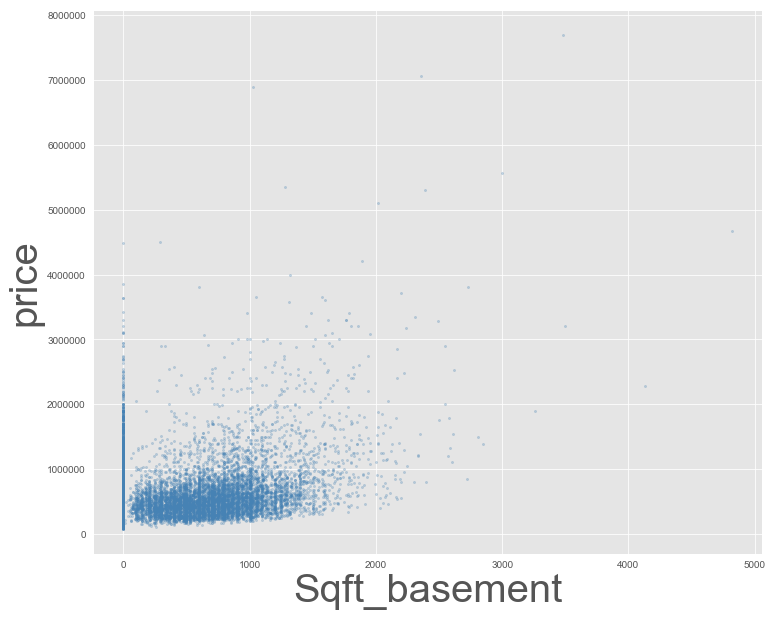

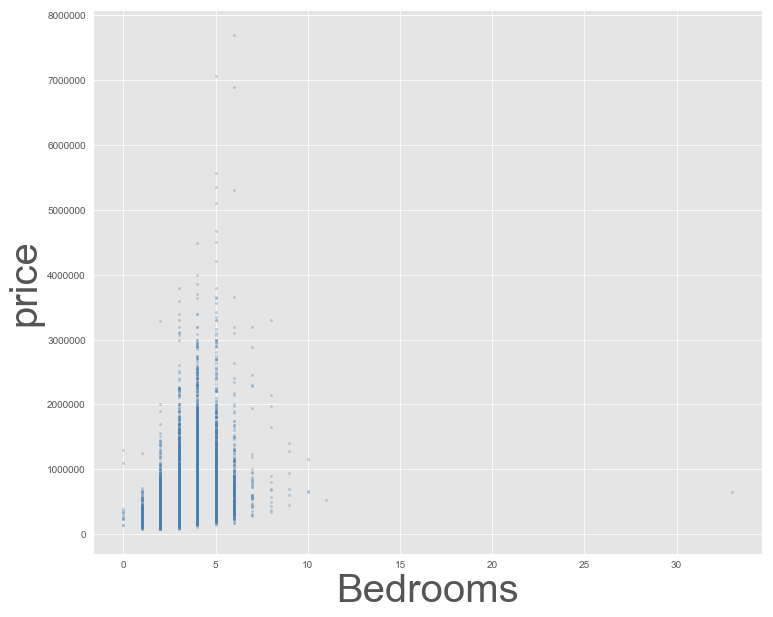

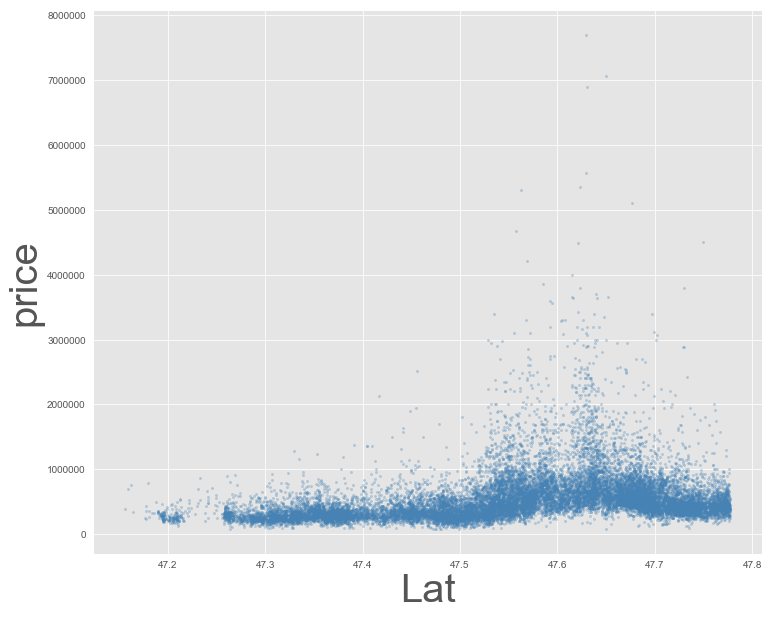

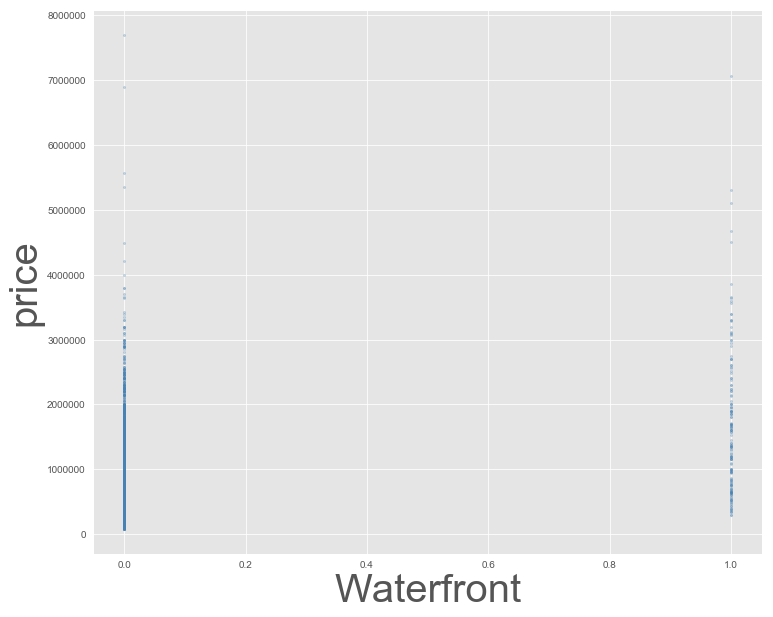

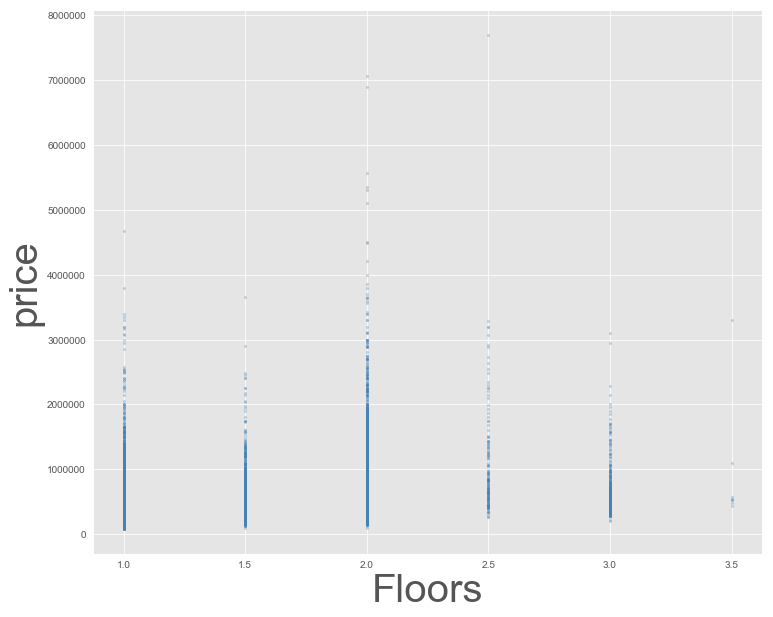

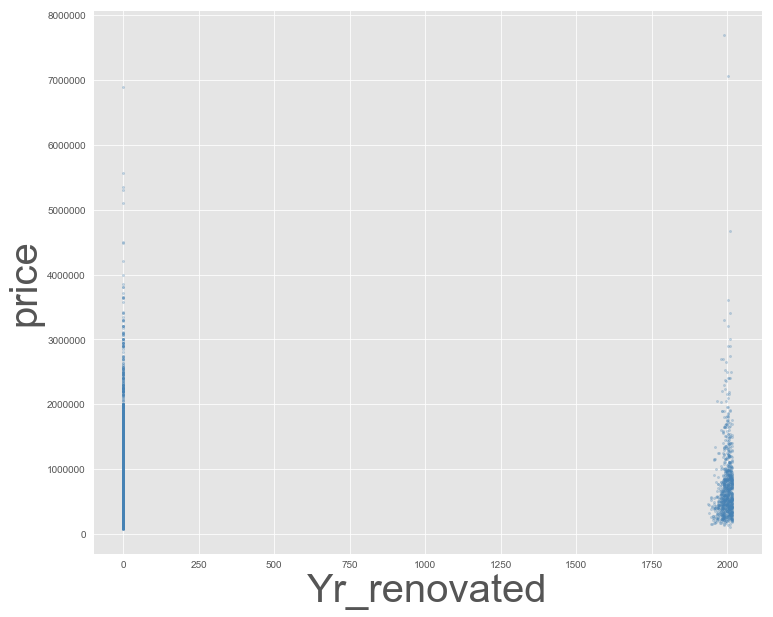

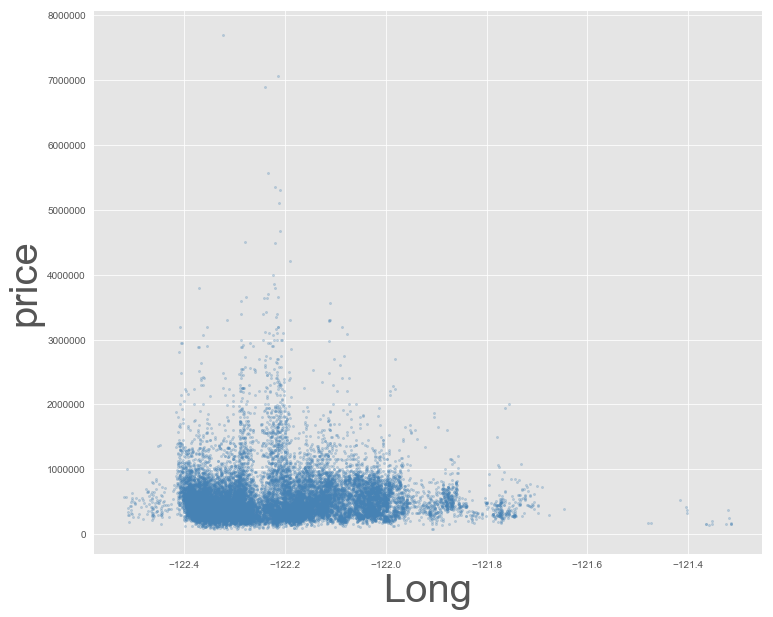

In [54]:
def feature_scatters(df, features, target):
    # plot numeric features against numberic target
    for f in features:
        plt.figure(figsize=(12,10))
        plt.scatter(df[f], df[target], c="SteelBlue", alpha=0.3, s=5)
        plt.xlabel(f.capitalize(), fontsize=40)
        plt.ylabel(target, fontsize=40)

feature_scatters(housing_df, features, "price")

### Observations from Scatterplots
* Several features with correlation coefficents greater than 0.1 with price appear to have a basically linear relationship to price according to the scatterplots, but several do not.  
 * Linear: square foot living, grade, square foot above, square foot living 15 (?), bathrooms, square foot basement
 * Non-linear: view, bedrooms, lat, waterfront, floors, year renovated
* Correlation coefficents of features with non-linear relationships are high enough that they should not be ingnored.  
## Conclusion: A non-linear model should be used.

## Preliminary Modeling

In [56]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler

/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [190]:
baseline = housing_df['price'].std()
print('Baseline score for model to beat: ${} (price std dev)'.format(round(baseline, 2)))

Baseline score for model to beat: $367362.23 (price std dev)


In [202]:
m = housing_df['price'].median()
print(m)

450000.0


In [206]:
errors = abs(m - housing_df['price'])
mae = np.mean(errors)

In [207]:
mae

221910.49442465184

In [164]:
X = housing_df.drop(["id", "price", "zipcode"], axis = 1)
y = housing_df['price']

In [165]:
# add transformed date
def transform_date():
    trans_date = []
    for d in housing_df['date'].values:
        trans_date.append(int(d[:8]))
    housing_df["transformed_date"] = trans_date

transform_date()

In [166]:
# check that it worked
print(housing_df[["date", "transformed_date"]].sample(5))
print(type(housing_df["transformed_date"][0]))

                  date  transformed_date
9237   20141007T000000          20141007
2422   20150217T000000          20150217
1404   20141216T000000          20141216
15484  20150406T000000          20150406
6826   20140527T000000          20140527
<class 'numpy.int64'>


### Split based on time and scale

In [167]:
# split at 70th percentile of date
split_date = np.percentile(housing_df['transformed_date'], 75)
print(split_date)

20150217.0


In [168]:
def split_by_date(df, date):
    train = housing_df[df['transformed_date'] <= date]
    test = housing_df[df['transformed_date'] > date]
    return train, test

def split_by_target(df, target):
    X = df.drop(target, axis=1)
    y = df[target]
    return X, y

train, test = split_by_date(housing_df, split_date)
X_train, y_train = split_by_target(train, "price")
X_test, y_test = split_by_target(test, "price")

In [169]:
X_train.shape[0] == y_train.shape[0] and X_test.shape[0] == y_test.shape[0]

True

In [170]:
X_train.drop("date", axis = 1, inplace=True)
X_test.drop("date", axis = 1, inplace=True)

In [171]:
scaler = StandardScaler()
fit_scaler = scaler.fit(X_train)

In [172]:
X_train_scaled = fit_scaler.transform(X_train)

In [173]:
knn = KNeighborsRegressor(n_jobs=-1)

In [174]:
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')

In [175]:
cross_validate(knn, X_train_scaled, y_train, cv=5, n_jobs=-1, return_train_score=True, scoring='neg_mean_absolute_error')

{'fit_time': array([0.10613775, 0.13161898, 0.26557493, 0.11173296, 0.43599415]),
 'score_time': array([1.53763986, 1.56622314, 1.39582515, 1.51561093, 1.57256603]),
 'test_score': array([-96115.28703419, -92722.24465661, -88038.40850277, -91391.43955638,
        -97490.70788663]),
 'train_score': array([-74820.43075857, -74361.2438968 , -75303.02642846, -75505.15937163,
        -74356.05874018])}

In [176]:
rf_model = RandomForestRegressor()

In [177]:
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [178]:
cross_validate(rf_model, X_train_scaled, y_train, cv=5, n_jobs=-1, return_train_score=True, scoring='neg_mean_absolute_error')

{'fit_time': array([1.23200512, 1.23805213, 1.21383715, 1.21701813, 1.25536203]),
 'score_time': array([0.01113892, 0.01150274, 0.01231003, 0.01147175, 0.01041007]),
 'test_score': array([-74591.86836567, -71386.33288163, -72906.37265866, -73876.00526802,
        -75194.38989526]),
 'train_score': array([-29254.63453254, -29662.26867539, -29404.99999487, -28945.61715437,
        -29553.07776837])}

In [179]:
gb_model = GradientBoostingRegressor()

In [180]:
gb_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [181]:
cross_validate(gb_model, X_train_scaled, y_train, cv=5, n_jobs=-1, return_train_score=True, scoring='neg_mean_absolute_error')

{'fit_time': array([2.17887378, 2.28383517, 2.26726317, 2.21891522, 2.17669606]),
 'score_time': array([0.00672507, 0.0054059 , 0.00660586, 0.00671196, 0.007056  ]),
 'test_score': array([-76328.56982016, -73736.8016544 , -71887.68383075, -79896.58587743,
        -76013.23778755]),
 'train_score': array([-69006.34274609, -70224.32734284, -69991.09595505, -69158.37865182,
        -69049.08664694])}

In [182]:
lr_model = LinearRegression()

In [183]:
cross_validate(lr_model, X_train_scaled, y_train, cv=5, n_jobs=-1, return_train_score=True, scoring='neg_mean_absolute_error')

{'fit_time': array([0.03712201, 0.03810906, 0.12109804, 0.14708614, 0.046736  ]),
 'score_time': array([0.00122118, 0.00103784, 0.02105093, 0.01927304, 0.00093818]),
 'test_score': array([-127695.77179271, -123667.98794297, -118933.06087152,
        -127525.03941942, -126221.68777802]),
 'train_score': array([-122460.34550785, -123024.18812602, -126259.87557808,
        -123616.59661594, -123195.20896738])}

In [184]:
svr_model = SVR()

In [185]:
cross_validate(svr_model, X_train_scaled, y_train, cv=5, n_jobs=-1, return_train_score=True, scoring='neg_mean_absolute_error')

{'fit_time': array([10.33899999, 10.33290696, 10.35212994, 10.30767703, 10.31531906]),
 'score_time': array([1.68364978, 1.6403861 , 1.65398192, 1.68770576, 1.66669178]),
 'test_score': array([-224557.18203261, -217499.60555462, -210248.79147184,
        -226444.47014754, -227490.16157097]),
 'train_score': array([-220296.02898273, -222061.5544647 , -223871.8906611 ,
        -219828.15865269, -219618.99674938])}

In [186]:
dt_model = DecisionTreeRegressor(splitter='best', max_depth=None, min_samples_split=10, min_samples_leaf=10, 
                                 min_weight_fraction_leaf=0.0, max_features=None, random_state=None, 
                                 max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, presort=False)

In [187]:
cross_validate(dt_model, X_train_scaled, y_train, cv=5, n_jobs=-1, return_train_score=True, scoring='neg_mean_absolute_error')

{'fit_time': array([0.13723493, 0.13136101, 0.13671207, 0.13396192, 0.13543415]),
 'score_time': array([0.00157809, 0.00177622, 0.00157094, 0.00155687, 0.00159693]),
 'test_score': array([-91160.76400652, -86250.37037739, -88922.32196392, -89221.3947798 ,
        -94007.41892008]),
 'train_score': array([-61767.89845409, -61986.07802964, -62421.01713812, -61932.53290461,
        -62031.53260951])}

# Conclusions of preliminary analysis
* The data are clean and appear to contain meaningful signal for predicting sale price
* The best out-of-the-box model is a Random Forest Regressor
 * With pruning to reduce overfitting, it should improve significantly

# Next Steps
* Build and tune Random Forest Regressor
* Productionalize model so predictions can be made in the field by our agents